# RoC Analysis Random Forest

## Data Generation
* Fix a beta* value and number of predictors
* Create a Y vector using Bernoulli distribution for logit
* Create a X vector using normal distribution as i.i.ds

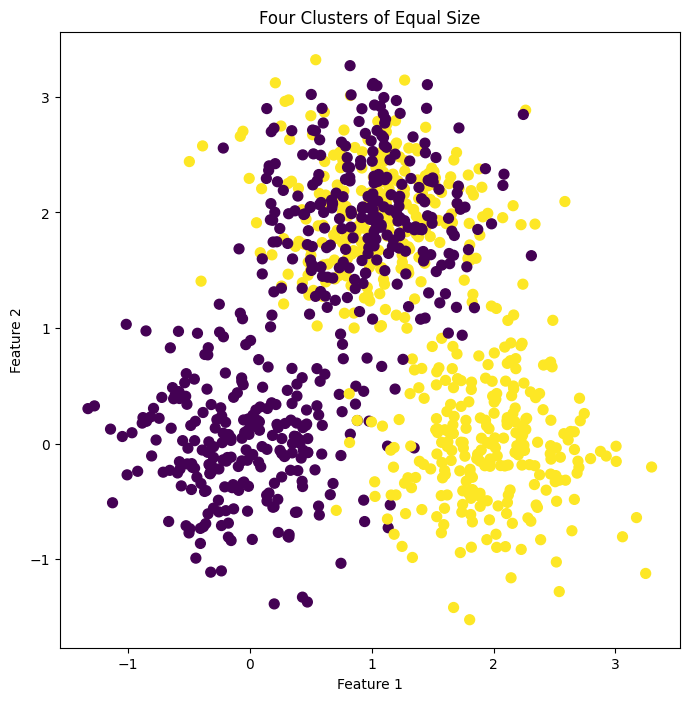

Training data shape: (800, 2), (800,)
Test data shape: (200, 2), (200,)


In [1]:
no_predictors = 2
no_samples = 1000
no_classes = 2
#kerneltype = 'linear'  #comment out for polynomial kernel
#kerneltype = 'poly'  #comment out for linear kernel

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

n_samples_per_cluster = 250
n_clusters = 4

# Create the clusters deterministically
np.random.seed(0) # for reproducibility

X = np.zeros((n_samples_per_cluster * n_clusters, 2))
y = np.zeros(n_samples_per_cluster * n_clusters)

# Cluster centers in corners of a square
centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

# Assign points to clusters deterministically
for i in range(n_clusters):
    cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
    X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
    if i == 0 or i == 3:
        y[cluster_indices] = 0
    else:
        y[cluster_indices] = 1



#Visualize
plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
plt.title('Four Clusters of Equal Size')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

#add intercept to X
#X = np.hstack((np.ones((X.shape[0], 1)), X))

# # shuffle data
# permutation = np.random.permutation(no_samples)
# X = X[permutation]
# y = y[permutation]


#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Test data shape: {X_test.shape}, {y_test.shape}")





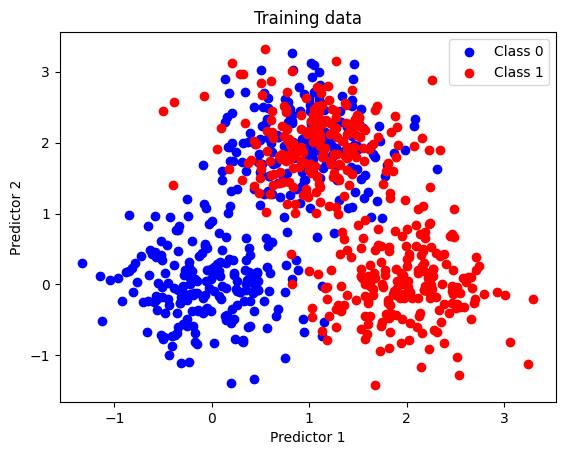

In [2]:
plt.figure()
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='b', label='Class 0') 
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Training data')
plt.show()

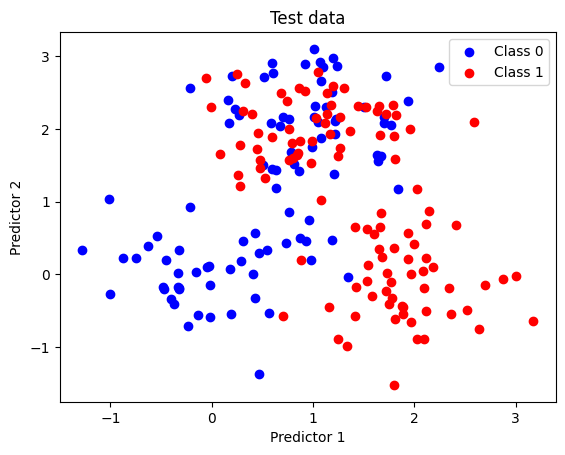

In [3]:
plt.figure()
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], color='b', label='Class 0') 
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], color='r', label='Class 1') 
plt.xlabel('Predictor 1') 
plt.ylabel('Predictor 2') 
plt.legend()
plt.title('Test data')
plt.show()

## Random Forest based classifier

In [4]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', random_state=42)

## Standard RoC curve

Length of threshold prc 74
Length of threshold_roc 66


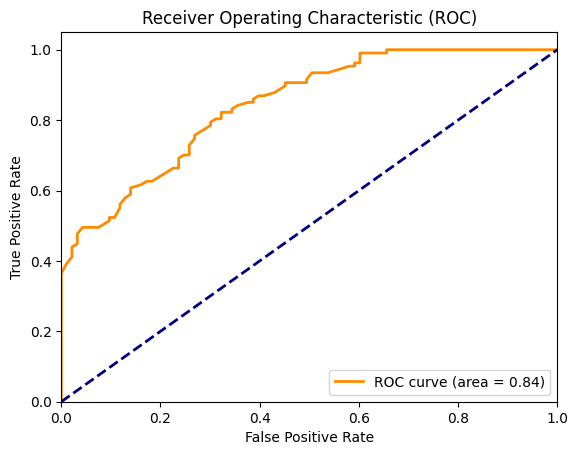

In [16]:
# Plot the RoC curve
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr_roc, tpr_roc, threshold_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
precision_prc, recall_prc, threshold_prc = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])

print("Length of threshold prc", len(threshold_prc))
print("Length of threshold_roc", len(threshold_roc))

roc_auc = auc(fpr_roc, tpr_roc)

# Plot the ROC curve
plt.figure()
plt.plot(fpr_roc, tpr_roc, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


### Function to calculate the AUC on the same X-axis as the weighted curve

In [6]:
def modified_auc_calc(fpr_roc, tpr_roc, fpr_roc_weighted_list, tpr_roc_weighted_list):
    """
    Calculate the modified area under the ROC curve (AUC).

    Parameters:
    fpr_roc (np.ndarray): False Positive Rates of the reference ROC curve.
    tpr_roc (np.ndarray): True Positive Rates of the reference ROC curve.
    fpr_roc_weighted_list (list): List of False Positive Rates for the weighted ROC points.
    tpr_roc_weighted_list (list): List of True Positive Rates for the weighted ROC points.
    """

    # 1. Convert list inputs to NumPy arrays.
    #    np.asarray() will convert the lists to NumPy arrays.
    #    If they were already arrays, it would generally not make a copy.
    fpr_weighted_np = np.asarray(fpr_roc_weighted_list)
    tpr_weighted_np = np.asarray(tpr_roc_weighted_list)

    # 2. Ensure these converted arrays are at least 1D.
    #    This guards against cases where an input might have resulted in a 0D array
    #    (which was the cause of your original ValueError).
    #    For lists like [0.1, 0.2], asarray already makes them 1D. This is a safety measure.
    fpr_weighted = np.atleast_1d(fpr_weighted_np)
    tpr_weighted = np.atleast_1d(tpr_weighted_np)

    # 3. Ensure fpr_roc and tpr_roc are treated as NumPy arrays.
    #    Since they are already arrays, np.asarray() is efficient and confirms their type.
    fpr_ref_np = np.asarray(fpr_roc)
    tpr_ref_np = np.asarray(tpr_roc)

    # 4. Perform the logic using these NumPy arrays.
    #    Get valid points where tpr_weighted is not 0 (and optionally not NaN)
    valid_condition = (tpr_weighted != 0)
    # Consider adding: & (~np.isnan(tpr_weighted)) if NaNs are possible
    
    valid_indices = np.where(valid_condition)
    
    fpr_weighted_valid = fpr_weighted[valid_indices]

    # Determine the min and max FPR from the valid weighted points
    fpr_weighted_min = np.min(fpr_weighted_valid)
    fpr_weighted_max = np.max(fpr_weighted_valid)
    
    # Modify the reference TPRs: use original TPR if FPR is within the weighted range, else 0.
    # This assumes fpr_ref_np and tpr_ref_np are of the same length and correspond element-wise.
    tpr_ref_modified = np.where(
        (fpr_ref_np >= fpr_weighted_min) & (fpr_ref_np <= fpr_weighted_max),
        tpr_ref_np,  # Use original TPR value
        0.0          # Otherwise, use 0.0
    )
    
    # Calculate the area using the trapezoidal rule.
    # Assumes fpr_ref_np is sorted for auc calculation (typical for ROC curves).
    # Assumes auc function signature is auc(fpr_values, tpr_values).
    # (e.g., from sklearn.metrics import auc)
    auc_value = auc(fpr_ref_np, tpr_ref_modified) 
    
    return auc_value

In [7]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_pred = clf_model.predict(X_test) # predict directly

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





## KDE approach for oversampling

In [18]:
EPSILON = 1e-9
# --- Function to process a single w value (for parallel execution) ---
def process_w_value(w, local_X_train, local_y_train, C0_init, C1_init, sigma_perturb, num_features, local_X_test, local_y_test):
    # This function is self-contained for each w. No shared state for synthetic sample lists.
    # Print statements inside this function will be interleaved if not careful or if verbose.
    # Consider reducing verbosity or using a logger for parallel execution.
    print(f"-- Processing w: {w:.4f} in parallel worker --")

    target_num_synthetic_C0_w = 0
    target_num_synthetic_C1_w = 0
    # Determine target synthetic counts for this w
    if C1_init == 0:
        if C0_init > 0 and w > EPSILON:
            _Class1_final_target = int(round(C0_init / w))
            if _Class1_final_target > C1_init: target_num_synthetic_C1_w = _Class1_final_target - C1_init
    elif C1_init > 0 and (w * C1_init >= C0_init - EPSILON):
        _Class0_final_target = int(round(C1_init * w))
        if _Class0_final_target > C0_init: target_num_synthetic_C0_w = _Class0_final_target - C0_init
    elif C1_init > 0 and (w * C1_init < C0_init - EPSILON):
        if w > EPSILON:
            _Class1_final_target = int(round(C0_init / w))
            if _Class1_final_target > C1_init: target_num_synthetic_C1_w = _Class1_final_target - C1_init
    elif C0_init == 0 and C1_init > 0:
        _Class0_final_target = int(round(C1_init * w))
        if _Class0_final_target > C0_init: target_num_synthetic_C0_w = _Class0_final_target

    # Generate synthetic samples FROM SCRATCH for this w
    X_new_synthetic_c0_w = []
    if target_num_synthetic_C0_w > 0:
        indices_class0 = np.where(local_y_train == 0)[0]
        if len(indices_class0) > 0:
            for _ in range(target_num_synthetic_C0_w):
                idx_star = np.random.choice(indices_class0)
                X_star = local_X_train[idx_star]
                epsilon_noise = np.random.randn(num_features) * sigma_perturb
                X_prime = X_star + epsilon_noise
                X_new_synthetic_c0_w.append(X_prime)
    
    X_new_synthetic_c1_w = []
    if target_num_synthetic_C1_w > 0:
        indices_class1 = np.where(local_y_train == 1)[0]
        if len(indices_class1) > 0:
            for _ in range(target_num_synthetic_C1_w):
                idx_star = np.random.choice(indices_class1)
                X_star = local_X_train[idx_star]
                epsilon_noise = np.random.randn(num_features) * sigma_perturb
                X_prime = X_star + epsilon_noise
                X_new_synthetic_c1_w.append(X_prime)

    X_s0_arr_w = np.array(X_new_synthetic_c0_w) if X_new_synthetic_c0_w else np.empty((0, num_features))
    X_s1_arr_w = np.array(X_new_synthetic_c1_w) if X_new_synthetic_c1_w else np.empty((0, num_features))

    res_parts_w = [local_X_train]
    if X_s0_arr_w.shape[0] > 0: res_parts_w.append(X_s0_arr_w)
    if X_s1_arr_w.shape[0] > 0: res_parts_w.append(X_s1_arr_w)
    X_resampled_w = np.vstack(res_parts_w)

    y_s0_w = np.zeros(len(X_new_synthetic_c0_w), dtype=local_y_train.dtype if local_y_train.size > 0 else int)
    y_s1_w = np.ones(len(X_new_synthetic_c1_w), dtype=local_y_train.dtype if local_y_train.size > 0 else int)
    y_resampled_w = np.concatenate((local_y_train, y_s0_w, y_s1_w))
    
    clf_weighted_w = RandomForestClassifier(random_state=42)
    if y_resampled_w.shape[0] > 0 and len(np.unique(y_resampled_w)) > 0 :
        clf_weighted_w.fit(X_resampled_w, y_resampled_w)
    else: clf_weighted_w.classes_ = np.array([0,1])

    res_w = get_fpr_tpr(clf_weighted_w, local_X_test, local_y_test)
    
    print(f"-- Finished w: {w:.4f} in worker. C0_syn={len(X_new_synthetic_c0_w)}, C1_syn={len(X_new_synthetic_c1_w)} --")
    return w, {
        "model": clf_weighted_w, "fpr": res_w["fpr"], "tpr": res_w["tpr"],
        "precision": res_w["precision"], "recall": res_w["recall"], "f1": res_w["f1"],
        "accuracy": res_w["accuracy"], "misclassification_rate": res_w["misclassification_rate"]
    }
# --- End of parallelizable function ---

INFO: Initial C0=407, C1=393, Ratio(0/1): 1.0356
INFO: Target ratios (w values) count: 100
INFO: KDE-like perturbation sigma: 0.1
INFO: n_features: 2 (fixed by constraint)
INFO: X_train_processed shape: (800, 2)
INFO: Parallelizing on 10 cores.


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.


-- Processing w: 0.0026 in parallel worker --
-- Processing w: 0.0020 in parallel worker --
-- Processing w: 0.0030 in parallel worker --
-- Processing w: 0.0010 in parallel worker --
-- Processing w: 0.0011 in parallel worker --
-- Processing w: 0.0023 in parallel worker --
-- Processing w: 0.0035 in parallel worker --
-- Processing w: 0.0015 in parallel worker ---- Processing w: 0.0017 in parallel worker --

-- Processing w: 0.0013 in parallel worker --
-- Finished w: 0.0035 in worker. C0_syn=0, C1_syn=116250 --
-- Processing w: 0.0040 in parallel worker --
-- Finished w: 0.0030 in worker. C0_syn=0, C1_syn=133625 --
-- Processing w: 0.0046 in parallel worker --
-- Finished w: 0.0026 in worker. C0_syn=0, C1_syn=153588 --
-- Processing w: 0.0053 in parallel worker --
-- Finished w: 0.0023 in worker. C0_syn=0, C1_syn=176524 --
-- Processing w: 0.0061 in parallel worker --
-- Finished w: 0.0040 in worker. C0_syn=0, C1_syn=101128 --
-- Processing w: 0.0070 in parallel worker --
-- Finishe

[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.1min


-- Finished w: 4.8446 in worker. C0_syn=1497, C1_syn=0 --
-- Finished w: 4.2106 in worker. C0_syn=1248, C1_syn=0 --
-- Processing w: 9.7685 in parallel worker --
-- Processing w: 11.2394 in parallel worker --
-- Finished w: 5.5741 in worker. C0_syn=1784, C1_syn=0 --
-- Processing w: 12.9318 in parallel worker --
-- Finished w: 6.4134 in worker. C0_syn=2113, C1_syn=0 --
-- Processing w: 14.8790 in parallel worker --
-- Finished w: 7.3791 in worker. C0_syn=2493, C1_syn=0 --
-- Processing w: 17.1193 in parallel worker --
-- Finished w: 8.4902 in worker. C0_syn=2930, C1_syn=0 --
-- Processing w: 19.6970 in parallel worker --
-- Finished w: 9.7685 in worker. C0_syn=3432, C1_syn=0 --
-- Processing w: 22.6629 in parallel worker --
-- Finished w: 11.2394 in worker. C0_syn=4010, C1_syn=0 --
-- Processing w: 26.0753 in parallel worker --
-- Finished w: 12.9318 in worker. C0_syn=4675, C1_syn=0 --
-- Processing w: 30.0016 in parallel worker --
-- Finished w: 14.8790 in worker. C0_syn=5440, C1_syn=

[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.3min finished


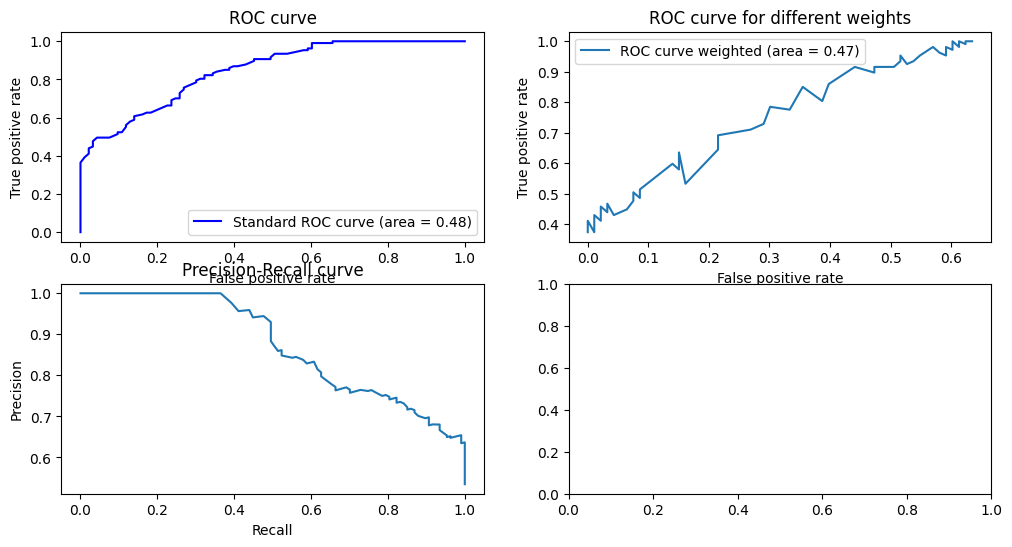

In [ ]:
import numpy as np
from collections import Counter
from joblib import Parallel, delayed # For parallelization
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed
N_CORES = 10 # Number of cores for parallelization

# --- Feature and X_train setup (Simplified by constraints) ---
n_features = 2  # Constraint: 2 features
# Constraint: X_train is never empty and assumed (N, 2)
X_train_processed = X_train

# --- Initial Data Analysis (Depends on y_train) ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.001
class_ratio_high = 1000.0
num_points_below = 50
num_points_above = 50

current_class_ratio_str = "N/A"
if Class1_initial == 0 and Class0_initial == 0:
    current_class_ratio = 1.0 
    current_class_ratio_str = "N/A (C0=0, C1=0)"
elif Class1_initial == 0:
    current_class_ratio = np.inf
    current_class_ratio_str = f"inf (C0={Class0_initial}, C1=0)"
else:
    current_class_ratio = Class0_initial / Class1_initial
    current_class_ratio_str = f"{current_class_ratio:.4f}"

# --- Alpha target generation (User's robust logic, kept as is) ---
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0:
    if not np.isinf(current_class_ratio) and current_class_ratio > 0:
         alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio) :
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass 
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio):
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low)
            if class_ratio_high > _start_geom_above:
                alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                if not np.isclose(_start_geom_above, current_class_ratio) and \
                   current_class_ratio >=_safe_class_ratio_low and \
                   current_class_ratio <= class_ratio_high and \
                   current_class_ratio not in alpha_target_list:
                    alpha_target_list.append(current_class_ratio)
                alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above) and class_ratio_high not in alpha_target_list:
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list : 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0 and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values) # Unique also sorts usually
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size : 
        if not np.isinf(current_class_ratio) and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([np.sqrt(_safe_class_ratio_low * class_ratio_high)])
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
            if not alpha_target_actual_values.size: 
                 alpha_target_actual_values = np.array([_safe_class_ratio_low]) 
elif Class0_initial == 0 and Class1_initial == 0: 
    alpha_target_actual_values = np.array([1.0]) 
else: 
    alpha_target_actual_values = np.array([1.0])
# --- End Alpha target generation ---

print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio_str}")
print(f"INFO: Target ratios (w values) count: {len(alpha_target_actual_values)}")
# print(f"INFO: Target ratios (w values): {alpha_target_actual_values}") # Can be long
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: n_features: {n_features} (fixed by constraint)")
print(f"INFO: X_train_processed shape: {X_train_processed.shape}")
print(f"INFO: Parallelizing on {N_CORES} cores.")

if __name__ == '__main__': # Important for joblib/multiprocessing on some platforms
    
    tasks = [delayed(process_w_value)(w_val, X_train_processed, y_train, 
                                     Class0_initial, Class1_initial, 
                                     SIGMA_KDE_PERTURBATION, n_features,
                                     X_test, y_test) 
             for w_val in alpha_target_actual_values]

    # Use backend="loky" (default) or "multiprocessing" or "threading"
    # "threading" might not give true parallelism for CPU-bound Python code due to GIL
    # "loky" or "multiprocessing" are better for CPU-bound tasks.
    results_list = Parallel(n_jobs=N_CORES, verbose=5)(tasks) # verbose shows progress

    # Collect results into dict_weighted_clfs
    dict_weighted_clfs = {res_w_val: res_dict for res_w_val, res_dict in results_list if res_w_val is not None}

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()

## KDE curve with synthetic samples from only the minority class
* Make Class0_initial = 0 so that current_class_ratio = 0 i.e oversample class 0
* Make Class1_initial = 0 so that current_class_ratio = inf i.e oversample class 1

In [ ]:
import numpy as np
from collections import Counter
from joblib import Parallel, delayed # For parallelization
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed
N_CORES = 10 # Number of cores for parallelization

# --- Feature and X_train setup (Simplified by constraints) ---
n_features = 2  # Constraint: 2 features
# Constraint: X_train is never empty and assumed (N, 2)
X_train_processed = X_train

# --- Initial Data Analysis (Depends on y_train) ---
counter = Counter(y_train)
# Class0_initial = counter.get(0, 0)
Class0_initial = 0
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.001
class_ratio_high = 1000.0
num_points_below = 50
num_points_above = 50

current_class_ratio_str = "N/A"
if Class1_initial == 0 and Class0_initial == 0:
    current_class_ratio = 1.0 
    current_class_ratio_str = "N/A (C0=0, C1=0)"
elif Class1_initial == 0:
    current_class_ratio = np.inf
    current_class_ratio_str = f"inf (C0={Class0_initial}, C1=0)"
else:
    current_class_ratio = Class0_initial / Class1_initial
    current_class_ratio_str = f"{current_class_ratio:.4f}"

# --- Alpha target generation (User's robust logic, kept as is) ---
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0:
    if not np.isinf(current_class_ratio) and current_class_ratio > 0:
         alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio) :
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass 
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio):
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low)
            if class_ratio_high > _start_geom_above:
                alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                if not np.isclose(_start_geom_above, current_class_ratio) and \
                   current_class_ratio >=_safe_class_ratio_low and \
                   current_class_ratio <= class_ratio_high and \
                   current_class_ratio not in alpha_target_list:
                    alpha_target_list.append(current_class_ratio)
                alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above) and class_ratio_high not in alpha_target_list:
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list : 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0 and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values) # Unique also sorts usually
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size : 
        if not np.isinf(current_class_ratio) and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([np.sqrt(_safe_class_ratio_low * class_ratio_high)])
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
            if not alpha_target_actual_values.size: 
                 alpha_target_actual_values = np.array([_safe_class_ratio_low]) 
elif Class0_initial == 0 and Class1_initial == 0: 
    alpha_target_actual_values = np.array([1.0]) 
else: 
    alpha_target_actual_values = np.array([1.0])
# --- End Alpha target generation ---

print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio_str}")
print(f"INFO: Target ratios (w values) count: {len(alpha_target_actual_values)}")
# print(f"INFO: Target ratios (w values): {alpha_target_actual_values}") # Can be long
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: n_features: {n_features} (fixed by constraint)")
print(f"INFO: X_train_processed shape: {X_train_processed.shape}")
print(f"INFO: Parallelizing on {N_CORES} cores.")

if __name__ == '__main__': # Important for joblib/multiprocessing on some platforms
    
    tasks = [delayed(process_w_value)(w_val, X_train_processed, y_train, 
                                     Class0_initial, Class1_initial, 
                                     SIGMA_KDE_PERTURBATION, n_features,
                                     X_test, y_test) 
             for w_val in alpha_target_actual_values]

    # Use backend="loky" (default) or "multiprocessing" or "threading"
    # "threading" might not give true parallelism for CPU-bound Python code due to GIL
    # "loky" or "multiprocessing" are better for CPU-bound tasks.
    results_list = Parallel(n_jobs=N_CORES, verbose=5)(tasks) # verbose shows progress

    # Collect results into dict_weighted_clfs
    dict_weighted_clfs = {res_w_val: res_dict for res_w_val, res_dict in results_list if res_w_val is not None}

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from collections import Counter
from joblib import Parallel, delayed # For parallelization
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed
N_CORES = 10 # Number of cores for parallelization

# --- Feature and X_train setup (Simplified by constraints) ---
n_features = 2  # Constraint: 2 features
# Constraint: X_train is never empty and assumed (N, 2)
X_train_processed = X_train

# --- Initial Data Analysis (Depends on y_train) ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
#Class1_initial = counter.get(1, 0)
Class1_initial = 0

class_ratio_low = 0.001
class_ratio_high = 1000.0
num_points_below = 50
num_points_above = 50

current_class_ratio_str = "N/A"
if Class1_initial == 0 and Class0_initial == 0:
    current_class_ratio = 1.0 
    current_class_ratio_str = "N/A (C0=0, C1=0)"
elif Class1_initial == 0:
    current_class_ratio = np.inf
    current_class_ratio_str = f"inf (C0={Class0_initial}, C1=0)"
else:
    current_class_ratio = Class0_initial / Class1_initial
    current_class_ratio_str = f"{current_class_ratio:.4f}"

# --- Alpha target generation (User's robust logic, kept as is) ---
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0:
    if not np.isinf(current_class_ratio) and current_class_ratio > 0:
         alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio) :
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass 
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio):
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low)
            if class_ratio_high > _start_geom_above:
                alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                if not np.isclose(_start_geom_above, current_class_ratio) and \
                   current_class_ratio >=_safe_class_ratio_low and \
                   current_class_ratio <= class_ratio_high and \
                   current_class_ratio not in alpha_target_list:
                    alpha_target_list.append(current_class_ratio)
                alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above) and class_ratio_high not in alpha_target_list:
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list : 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0 and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values) # Unique also sorts usually
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size : 
        if not np.isinf(current_class_ratio) and current_class_ratio >= _safe_class_ratio_low and current_class_ratio <= class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([np.sqrt(_safe_class_ratio_low * class_ratio_high)])
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low]
            alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
            if not alpha_target_actual_values.size: 
                 alpha_target_actual_values = np.array([_safe_class_ratio_low]) 
elif Class0_initial == 0 and Class1_initial == 0: 
    alpha_target_actual_values = np.array([1.0]) 
else: 
    alpha_target_actual_values = np.array([1.0])
# --- End Alpha target generation ---

print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio_str}")
print(f"INFO: Target ratios (w values) count: {len(alpha_target_actual_values)}")
# print(f"INFO: Target ratios (w values): {alpha_target_actual_values}") # Can be long
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: n_features: {n_features} (fixed by constraint)")
print(f"INFO: X_train_processed shape: {X_train_processed.shape}")
print(f"INFO: Parallelizing on {N_CORES} cores.")

if __name__ == '__main__': # Important for joblib/multiprocessing on some platforms
    
    tasks = [delayed(process_w_value)(w_val, X_train_processed, y_train, 
                                     Class0_initial, Class1_initial, 
                                     SIGMA_KDE_PERTURBATION, n_features,
                                     X_test, y_test) 
             for w_val in alpha_target_actual_values]

    # Use backend="loky" (default) or "multiprocessing" or "threading"
    # "threading" might not give true parallelism for CPU-bound Python code due to GIL
    # "loky" or "multiprocessing" are better for CPU-bound tasks.
    results_list = Parallel(n_jobs=N_CORES, verbose=5)(tasks) # verbose shows progress

    # Collect results into dict_weighted_clfs
    dict_weighted_clfs = {res_w_val: res_dict for res_w_val, res_dict in results_list if res_w_val is not None}

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()

## Update method for RoC-like curve generation (KDE-like approach)*
* Generate new sample as:
$$X^* \sim \textit{Unif}[0,len(Y_{train})]$$
$$X' = X^* + \sigma \epsilon$$
where $\sigma \leq 0.5$ the standard deviation in the original data and $\epsilon \sim \mathcal{N}[0,1]$
* Classify the synthetic sample as the oversampled class

INFO: Initial C0=407, C1=393, Ratio(0/1): 1.0356234096692112
INFO: Target ratios (w values): [ 0.1         0.10236512  0.10478619  0.10726451  0.10980145  0.11239839
  0.11505675  0.11777799  0.12056358  0.12341506  0.12633398  0.12932194
  0.13238056  0.13551153  0.13871654  0.14199736  0.14535578  0.14879362
  0.15231278  0.15591516  0.15960275  0.16337755  0.16724164  0.17119711
  0.17524613  0.17939092  0.18363374  0.18797691  0.1924228   0.19697383
  0.20163251  0.20640137  0.21128302  0.21628013  0.22139542  0.2266317
  0.23199182  0.23747871  0.24309538  0.24884489  0.25473038  0.26075507
  0.26692225  0.2732353   0.27969765  0.28631285  0.2930845   0.30001632
  0.30711207  0.31437566  0.32181103  0.32942226  0.33721351  0.34518903
  0.35335318  0.36171042  0.37026532  0.37902256  0.38798691  0.39716329
  0.40655669  0.41617226  0.42601526  0.43609105  0.44640514  0.45696318
  0.46777093  0.47883429  0.49015932  0.5017522   0.51361926  0.52576699
  0.53820204  0.55093119  0.5639

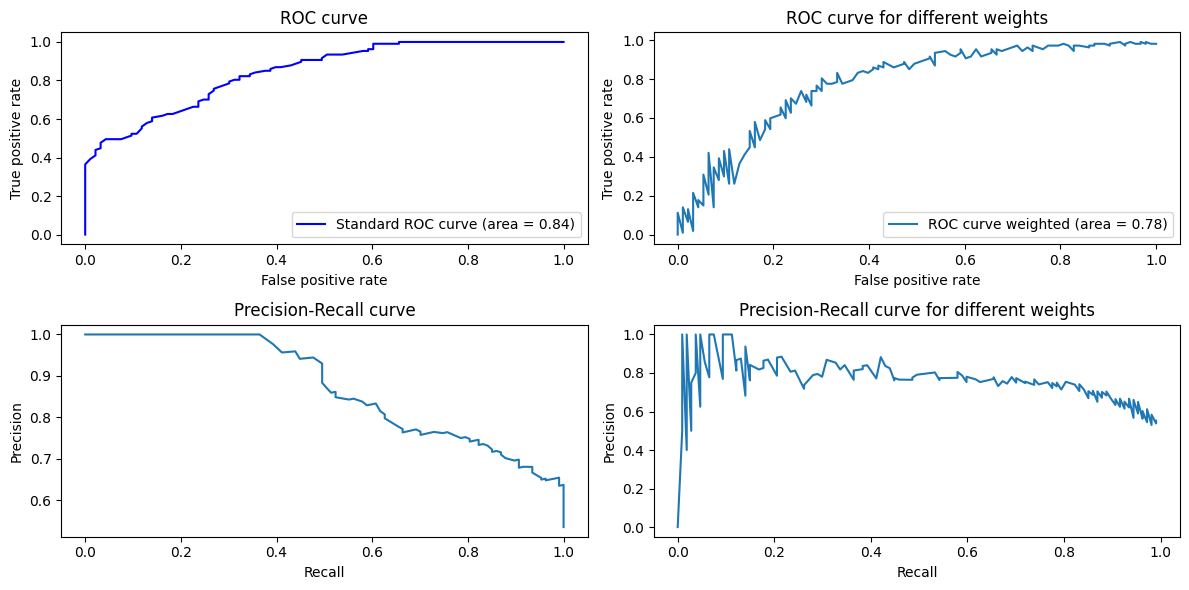

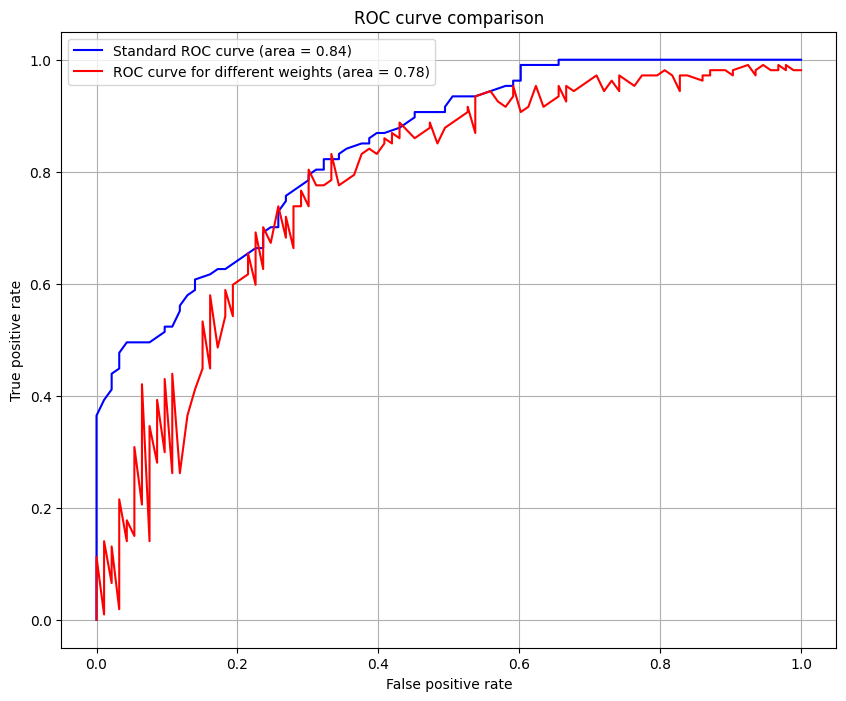

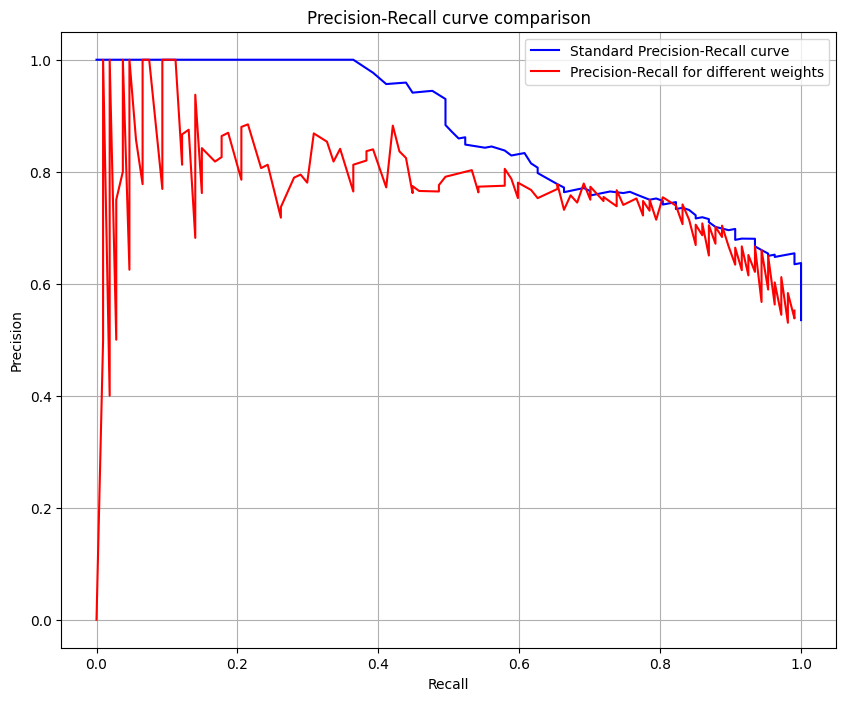

In [ ]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.001   
class_ratio_high = 1000.0 
num_points_below = 100 
num_points_above = 100 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            idx_star = np.random.randint(0, len(X_train))
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")

## KDE curve with synthetic samples from only the minority class
* Make Class0_initial = 0 so that current_class_ratio = 0 i.e oversample class 0
* Make Class1_initial = 0 so that current_class_ratio = inf i.e oversample class 1

INFO: Initial C0=0, C1=393, Ratio(0/1): 0.0
INFO: Target ratios (w values): [1.00000000e-03 1.32571137e-03 1.75751062e-03 2.32995181e-03
 3.08884360e-03 4.09491506e-03 5.42867544e-03 7.19685673e-03
 9.54095476e-03 1.26485522e-02 1.67683294e-02 2.22299648e-02
 2.94705170e-02 3.90693994e-02 5.17947468e-02 6.86648845e-02
 9.10298178e-02 1.20679264e-01 1.59985872e-01 2.12095089e-01
 2.81176870e-01 3.72759372e-01 4.94171336e-01 6.55128557e-01
 8.68511374e-01 1.15139540e+00 1.52641797e+00 2.02358965e+00
 2.68269580e+00 3.55648031e+00 4.71486636e+00 6.25055193e+00
 8.28642773e+00 1.09854114e+01 1.45634848e+01 1.93069773e+01
 2.55954792e+01 3.39322177e+01 4.49843267e+01 5.96362332e+01
 7.90604321e+01 1.04811313e+02 1.38949549e+02 1.84206997e+02
 2.44205309e+02 3.23745754e+02 4.29193426e+02 5.68986603e+02
 7.54312006e+02 1.00000000e+03]
INFO: KDE-like perturbation sigma: 0.1
INFO: Standard deviation of synthetic samples will NOT be modified after generation.

--- Processing target ratio w (1/50

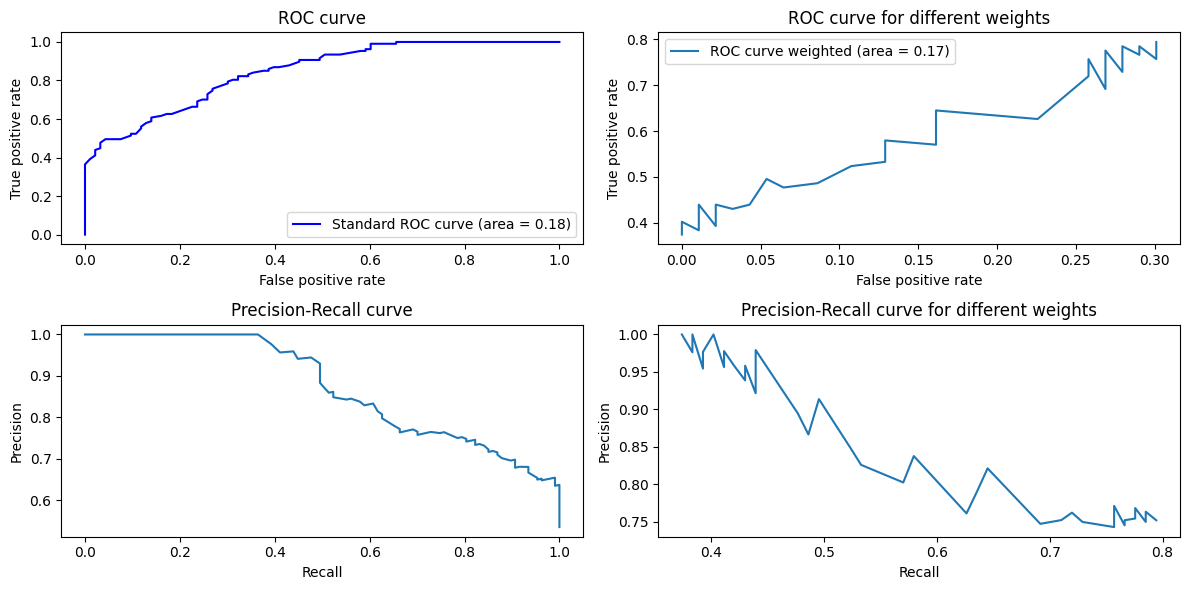

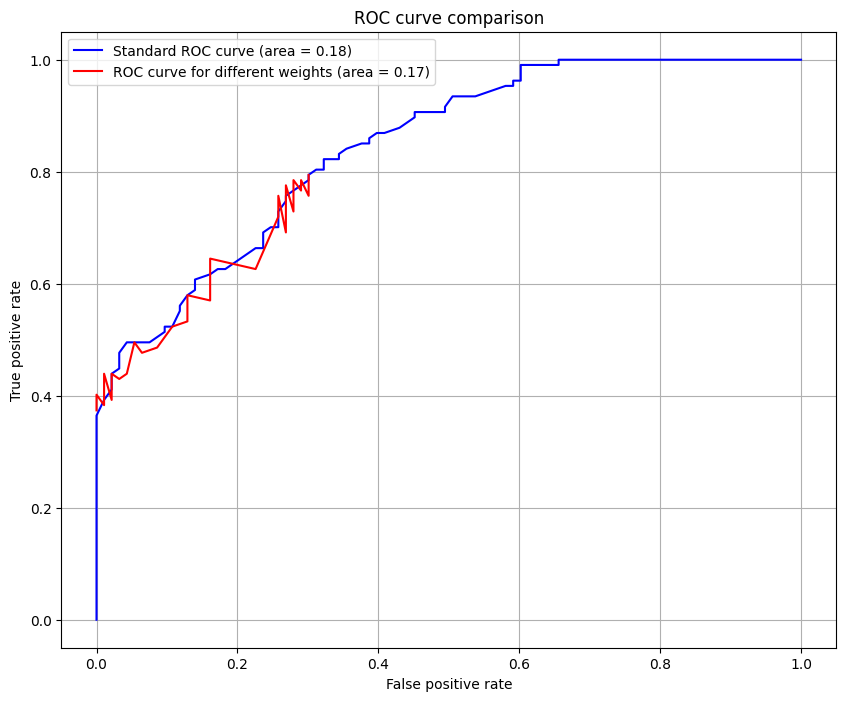

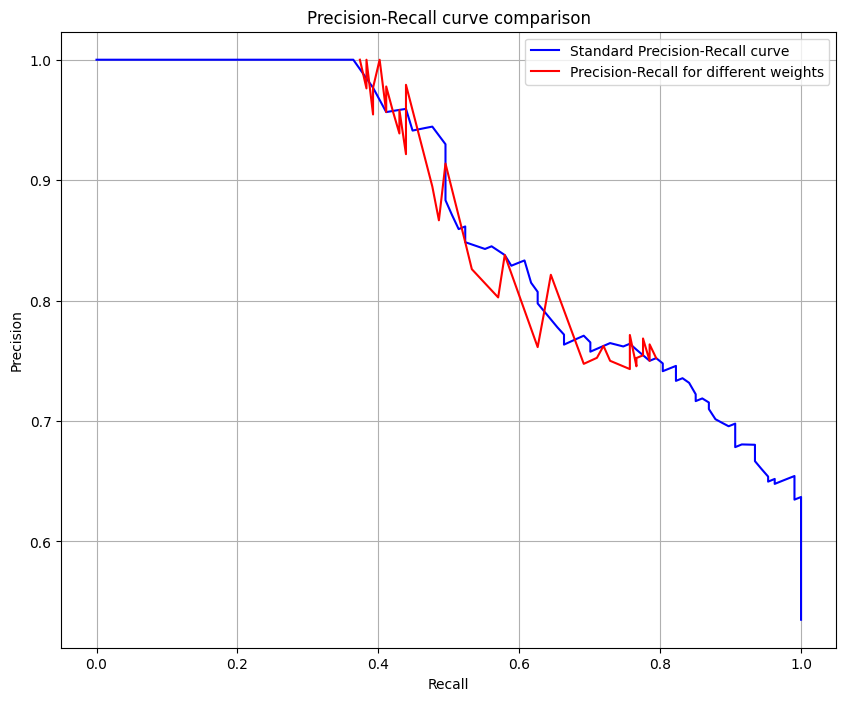

In [10]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
#Class0_initial = counter.get(0, 0)
Class0_initial = 0
Class1_initial = counter.get(1, 0)

class_ratio_low = 0.001   
class_ratio_high = 1000.0 
num_points_below = 50 
num_points_above = 50 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    indices_class_0 = np.where(y_train == 0)[0]

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            #idx_star = np.random.randint(0, len(X_train))
            idx_star = np.random.choice(indices_class_0)  # Ensure we sample from class 0
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")

INFO: Initial C0=407, C1=0, Ratio(0/1): N/A
INFO: Target ratios (w values): [1.00000000e-03 1.14975700e-03 1.32194115e-03 1.51991108e-03
 1.74752840e-03 2.00923300e-03 2.31012970e-03 2.65608778e-03
 3.05385551e-03 3.51119173e-03 4.03701726e-03 4.64158883e-03
 5.33669923e-03 6.13590727e-03 7.05480231e-03 8.11130831e-03
 9.32603347e-03 1.07226722e-02 1.23284674e-02 1.41747416e-02
 1.62975083e-02 1.87381742e-02 2.15443469e-02 2.47707636e-02
 2.84803587e-02 3.27454916e-02 3.76493581e-02 4.32876128e-02
 4.97702356e-02 5.72236766e-02 6.57933225e-02 7.56463328e-02
 8.69749003e-02 1.00000000e-01 1.14975700e-01 1.32194115e-01
 1.51991108e-01 1.74752840e-01 2.00923300e-01 2.31012970e-01
 2.65608778e-01 3.05385551e-01 3.51119173e-01 4.03701726e-01
 4.64158883e-01 5.33669923e-01 6.13590727e-01 7.05480231e-01
 8.11130831e-01 9.32603347e-01 1.07226722e+00 1.23284674e+00
 1.41747416e+00 1.62975083e+00 1.87381742e+00 2.15443469e+00
 2.47707636e+00 2.84803587e+00 3.27454916e+00 3.76493581e+00
 4.328761

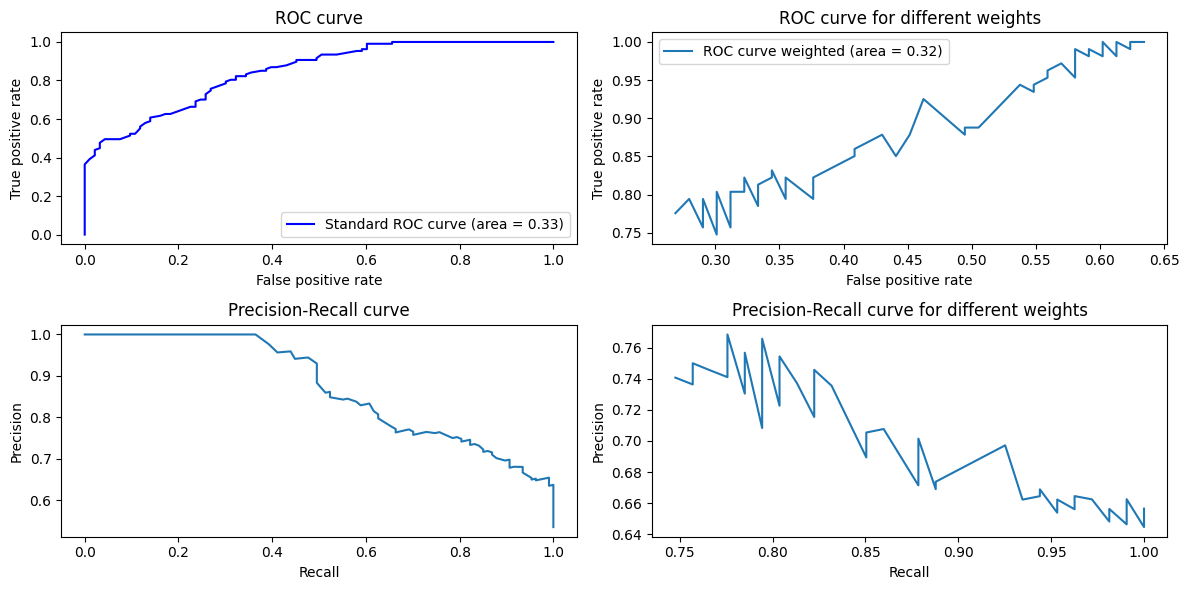

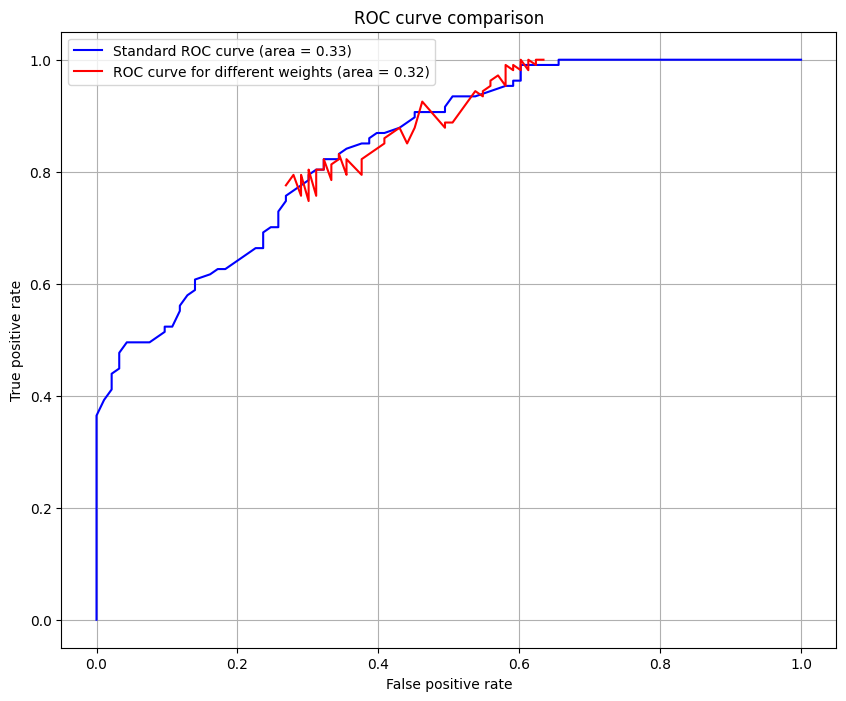

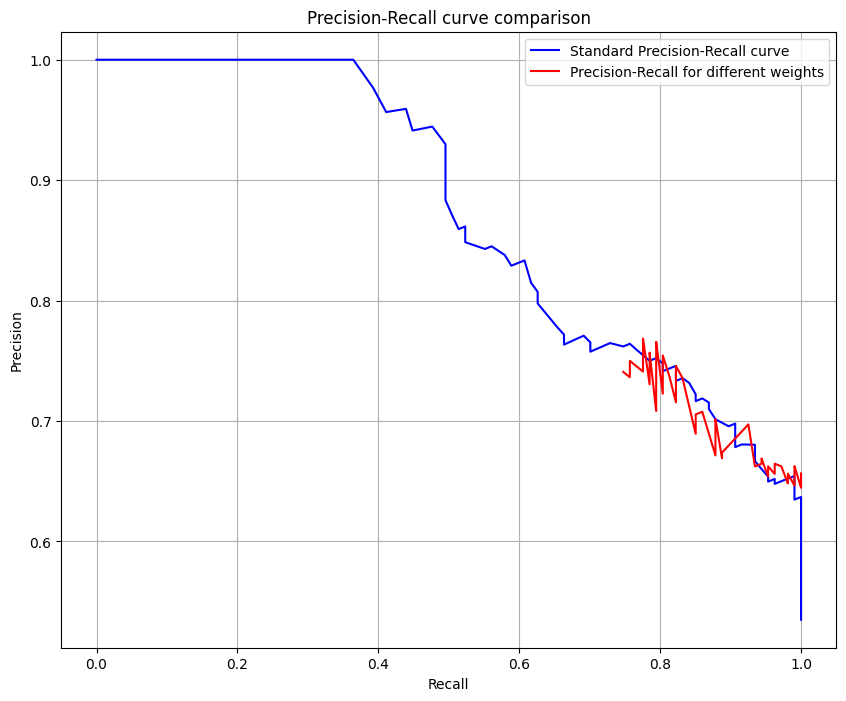

In [11]:
import numpy as np
from collections import Counter
# from imblearn.over_sampling import SMOTE # SMOTE is no longer used
# from sklearn.cluster import KMeans # K-Means is no longer used

# --- Configuration ---
EPSILON = 1e-9
# EXPECTED_MODES_PER_CLASS, etc. removed
# FIXED_TARGET_STD_SYNTHETIC removed

# --- Parameter for KDE-like generator ---
SIGMA_KDE_PERTURBATION = 0.1 # Adjust as needed



# --- Initial Data Analysis ---
counter = Counter(y_train)
Class0_initial = counter.get(0, 0)
#Class1_initial = counter.get(1, 0)
Class1_initial = 0

class_ratio_low = 0.001   
class_ratio_high = 1000.0 
num_points_below = 50 
num_points_above = 50 

if Class1_initial == 0 and Class0_initial == 0:
    print("ERROR: Both classes have zero samples initially. Cannot proceed.")
    alpha_target_actual_values = [] 
    current_class_ratio = 1.0
elif Class1_initial == 0:
    current_class_ratio = np.inf 
else:
    current_class_ratio = Class0_initial / Class1_initial

# ... (alpha_target_actual_values generation - same robust version) ...
alpha_target_list = []
if Class0_initial > 0 or Class1_initial > 0: 
    if current_class_ratio > 0 and not np.isinf(current_class_ratio): 
        alpha_target_list.append(current_class_ratio)
    _safe_class_ratio_low = max(class_ratio_low, EPSILON)
    if current_class_ratio > _safe_class_ratio_low and not np.isinf(current_class_ratio): 
        try:
            alpha_b = np.geomspace(_safe_class_ratio_low, current_class_ratio, num_points_below, endpoint=False)
            alpha_target_list.extend(alpha_b)
        except ValueError: pass
    if current_class_ratio < class_ratio_high and current_class_ratio >= 0 and not np.isinf(current_class_ratio): 
        try:
            _start_geom_above = max(current_class_ratio, _safe_class_ratio_low) 
            if class_ratio_high > _start_geom_above:
                 alpha_a = np.geomspace(_start_geom_above, class_ratio_high, num_points_above, endpoint=True)
                 if not np.isclose(_start_geom_above, current_class_ratio) and current_class_ratio >=_safe_class_ratio_low and current_class_ratio <= class_ratio_high :
                     alpha_target_list.append(current_class_ratio)
                 alpha_target_list.extend(alpha_a)
            elif np.isclose(class_ratio_high, _start_geom_above):
                 alpha_target_list.append(class_ratio_high)
        except ValueError: pass
    if not alpha_target_list and (Class0_initial > 0 or Class1_initial > 0): 
        if not np.isinf(current_class_ratio) and current_class_ratio > 0:
            alpha_target_list.append(current_class_ratio)
        else: 
            alpha_target_list.extend(np.geomspace(_safe_class_ratio_low, class_ratio_high, num_points_below + num_points_above))
    alpha_target_actual_values = np.unique(alpha_target_list)
    alpha_target_actual_values = np.sort(alpha_target_actual_values[alpha_target_actual_values >= 0]) 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values >= _safe_class_ratio_low] 
    alpha_target_actual_values = alpha_target_actual_values[alpha_target_actual_values <= class_ratio_high]
    if not alpha_target_actual_values.size and (Class0_initial > 0 or Class1_initial > 0) : 
        if not np.isinf(current_class_ratio) and current_class_ratio > _safe_class_ratio_low and current_class_ratio < class_ratio_high:
            alpha_target_actual_values = np.array([current_class_ratio])
        else: 
            alpha_target_actual_values = np.array([(_safe_class_ratio_low + class_ratio_high)/2.0])


print(f"INFO: Initial C0={Class0_initial}, C1={Class1_initial}, Ratio(0/1): {current_class_ratio if Class1_initial > 0 else 'N/A'}")
print(f"INFO: Target ratios (w values): {alpha_target_actual_values}")
print(f"INFO: KDE-like perturbation sigma: {SIGMA_KDE_PERTURBATION}")
print(f"INFO: Standard deviation of synthetic samples will NOT be modified after generation.")

dict_weighted_clfs = {}

# --- Main Loop ---
for w_idx, w in enumerate(alpha_target_actual_values):
    print(f"\n--- Processing target ratio w ({w_idx+1}/{len(alpha_target_actual_values)}): {w:.4f} ---")

    # --- Determine Oversampling Strategy ---
    sampling_strategy_determined = False
    oversampled_class_label_by_strategy = -1
    initial_count_of_oversampled_class = -1
    final_count_of_oversampled_class = -1
    num_synthetic_to_generate = 0

    if Class1_initial == 0:
        if Class0_initial > 0 and w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    elif w >= current_class_ratio: 
        _Class0_final = int(round(Class1_initial * w))
        if _Class0_final > Class0_initial:
            oversampled_class_label_by_strategy = 0
            initial_count_of_oversampled_class = Class0_initial
            final_count_of_oversampled_class = _Class0_final
            sampling_strategy_determined = True
    elif w < current_class_ratio: 
        if w > EPSILON: 
            _Class1_final = int(round(Class0_initial / w))
            if _Class1_final > Class1_initial:
                oversampled_class_label_by_strategy = 1
                initial_count_of_oversampled_class = Class1_initial
                final_count_of_oversampled_class = _Class1_final
                sampling_strategy_determined = True
    

    
    num_synthetic_to_generate = final_count_of_oversampled_class - initial_count_of_oversampled_class
    print(f"  INFO: Strategy: Oversample class {oversampled_class_label_by_strategy} from {initial_count_of_oversampled_class} to {final_count_of_oversampled_class} (generating {num_synthetic_to_generate} samples).")



    # --- KDE-like Synthetic Sample Generation ---
    print(f"  INFO: Using KDE-like generator. Perturbation sigma: {SIGMA_KDE_PERTURBATION}")
    X_new_synthetic = []
    y_new_synthetic = []

    indices_class_1 = np.where(y_train == 1)[0]

    if len(X_train) == 0:
        print("  WARNING: X_train is empty, cannot generate synthetic samples with KDE-like method.")
        X_resampled = X_train.copy()
        y_resampled = y_train.copy()
    else:
        for _ in range(num_synthetic_to_generate):
            #idx_star = np.random.randint(0, len(X_train))
            idx_star = np.random.choice(indices_class_1)
            X_star = X_train[idx_star]
            epsilon_noise = np.random.randn(*X_star.shape) 
            X_prime = X_star + SIGMA_KDE_PERTURBATION * epsilon_noise
            X_new_synthetic.append(X_prime)
            y_new_synthetic.append(oversampled_class_label_by_strategy)

        if not X_new_synthetic:
            print("  INFO: No synthetic samples were actually generated by KDE-like method.")
            X_resampled = X_train.copy()
            y_resampled = y_train.copy()
        else:
            X_new_synthetic_arr = np.array(X_new_synthetic)
            y_new_synthetic_arr = np.array(y_new_synthetic)
            X_resampled = np.vstack((X_train, X_new_synthetic_arr))
            y_resampled = np.concatenate((y_train, y_new_synthetic_arr))
            resampled_counts = Counter(y_resampled)
            print(f"  INFO: KDE-like generation complete. New C0={resampled_counts.get(0,0)}, C1={resampled_counts.get(1,0)}")

    # Fit the Random Forest classifier with the resampled data
    clf_weighted = RandomForestClassifier(random_state=42)
    clf_weighted.fit(X_resampled, y_resampled)

    res = get_fpr_tpr(clf_weighted, X_test, y_test)
    dict_weighted_clfs[w] = {
        "model": clf_weighted,
        "fpr": res["fpr"],
        "tpr": res["tpr"],
        "precision": res["precision"],
        "recall": res["recall"],
        "f1": res["f1"],
        "accuracy": res["accuracy"],
        "misclassification_rate": res["misclassification_rate"]
    }
    #print(f"Weight: {w:.2f}, FPR: {res['fpr']:.3f}, TPR: {res['tpr']:.3f}")

# Extract and sort FPR and TPR values from the weighted classifiers
fpr_weighted = [v["fpr"] for v in dict_weighted_clfs.values()]
tpr_weighted = [v["tpr"] for v in dict_weighted_clfs.values()]
roc_points = sorted(zip(fpr_weighted, tpr_weighted))
fpr_weighted_sorted = [p[0] for p in roc_points]
tpr_weighted_sorted = [p[1] for p in roc_points]

# Calculate AUC for weighted ROC curve
roc_auc_weighted = auc(fpr_weighted_sorted, tpr_weighted_sorted)
roc_auc = modified_auc_calc(fpr_roc, tpr_roc, fpr_weighted_sorted, tpr_weighted_sorted)

# Plot the FPR vs TPR for the different weights
fig,ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
ax[0][0].set_xlabel('False positive rate')
ax[0][0].set_ylabel('True positive rate')
ax[0][0].set_title('ROC curve')
ax[0][0].legend()
ax[0][1].plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve weighted (area = {roc_auc_weighted:.2f})')
ax[0][1].set_xlabel('False positive rate')
ax[0][1].set_ylabel('True positive rate')
ax[0][1].set_title('ROC curve for different weights')
ax[0][1].legend()
ax[1][0].plot(recall_prc, precision_prc)
ax[1][0].set_xlabel('Recall')
ax[1][0].set_ylabel('Precision')
ax[1][0].set_title('Precision-Recall curve')

# Extract and sort precision-recall values
recall_weighted = [v["recall"] for v in dict_weighted_clfs.values()]
precision_weighted = [v["precision"] for v in dict_weighted_clfs.values()]
pr_points = sorted(zip(recall_weighted, precision_weighted))
recall_weighted_sorted = [p[0] for p in pr_points]
precision_weighted_sorted = [p[1] for p in pr_points]

ax[1][1].plot(recall_weighted_sorted, precision_weighted_sorted)
ax[1][1].set_xlabel('Recall')
ax[1][1].set_ylabel('Precision')
ax[1][1].set_title('Precision-Recall curve for different weights')
plt.tight_layout()
plt.show()

# Plot both ROC curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(fpr_roc, tpr_roc, label=f'Standard ROC curve (area = {roc_auc:.2f})', color='blue')
plt.plot(fpr_weighted_sorted, tpr_weighted_sorted, label=f'ROC curve for different weights (area = {roc_auc_weighted:.2f})', color='red')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend()
plt.title('ROC curve comparison')
plt.grid(True)
plt.show()

# Plot both Precision-Recall curves on the same plot figure
plt.figure(figsize=(10, 8))
plt.plot(recall_prc, precision_prc, label='Standard Precision-Recall curve', color='blue')
plt.plot(recall_weighted_sorted, precision_weighted_sorted, label='Precision-Recall for different weights', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('Precision-Recall curve comparison')
plt.grid(True)
plt.show()


#print(f"\n--- Finished processing. {len(dict_weighted_clfs)} scenarios stored in dict_weighted_clfs. ---")